In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import tensorflow as tf

In [3]:
# #HARDcoded 
EPOCHS=20
TEST_SIZE=0.1
TIME_STEP=24
BATCH_SIZE = 32

In [18]:
#Load data
weather=pd.read_csv("Dataset/Weather_History.csv")

In [19]:
weather.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,0,1016.51,Partly cloudy throughout the day.


In [20]:
weather.shape

(96453, 12)

In [21]:
#Data Preprocessing
weather['datetime']=pd.to_datetime(weather['Formatted Date'],utc=True)#UTC to consider the time format is uts so the operations can be done
# weather.head()
weather=weather[['datetime','Temperature (C)']]
weather=weather.rename({'Temperature (C)':'temp'},axis=1)
weather=weather.sort_values('datetime',axis=0,ascending=True)
weather=weather.reset_index(drop=True)
# weather.head()
weather.shape

(96453, 2)

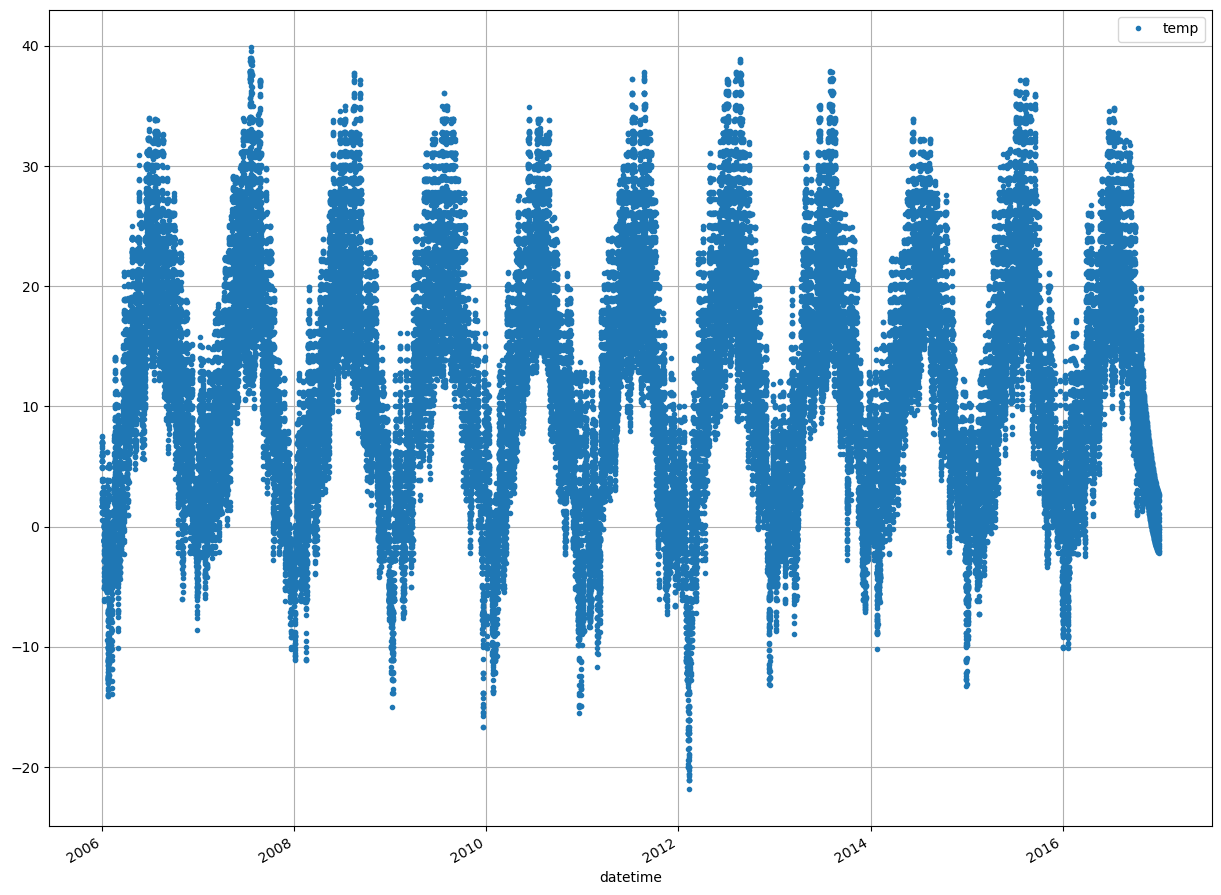

In [8]:
#Datetime representation
fig, ax = plt.subplots(figsize = (15,12))
weather.plot(x='datetime', y='temp', style=".", ax = ax);
ax.grid()

Now we want X and Y
So for this data X will contain  weather data of 23 hours and we will predict the 24th hour <br>
Therefore:<br>
X=df[0:23] for each time step<br>
Y=df[-1]<br>

In [9]:
#Creating Y
Y_filt=np.arange(TIME_STEP,weather.shape[0],TIME_STEP) #Filter :(24,number_of _rows,24)
Y_filt

array([   24,    48,    72, ..., 96384, 96408, 96432])

In [14]:
y_df=weather.iloc[Y_filt] #Fitting filter on weather data
y_df.head()
# len(y_df)
#24 hours label 

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [10]:
weather.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [24]:
#Creating X
X_temp=weather.iloc[range(len(y_df)*TIME_STEP)] # Whole data till last element of y_df
X_temp
X=np.reshape(X_temp['temp'].values,(y_df.shape[0], TIME_STEP,1)) #(X_temp array,in the shape of(4018,24))
X.shape
X[:,23]
# X=X[:,:23] #Excluding 24th 
# X.shape
# X

array([[ 5.42222222],
       [ 1.69444444],
       [ 2.2       ],
       ...,
       [-1.4       ],
       [-1.44444444],
       [-1.48888889]])

In [12]:
split = int(y_df.shape[0] * (1-TEST_SIZE))
X_train = X[:split]
X_test = X[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3616, 23, 1), (402, 23, 1), (3616,), (402,))

In [45]:
h_units = 32
input_shape=(TIME_STEP-1, 1 ) # we are using one feature only.

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(units = h_units, input_shape = input_shape, activation = 'sigmoid'))

model.add(tf.keras.layers.Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

C:\Users\adity\OneDrive - IIT Delhi\Anaconda installation\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_split=0.20,
                    batch_size= BATCH_SIZE, 
                    verbose=1)

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9464 - root_mean_squared_error: 0.9720 - val_loss: 0.7835 - val_root_mean_squared_error: 0.8852
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0417 - root_mean_squared_error: 1.0202 - val_loss: 0.7765 - val_root_mean_squared_error: 0.8812
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9527 - root_mean_squared_error: 0.9756 - val_loss: 0.7782 - val_root_mean_squared_error: 0.8822
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9758 - root_mean_squared_error: 0.9873 - val_loss: 0.7775 - val_root_mean_squared_error: 0.8817
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9673 - root_mean_squared_error: 0.9820 - val_loss: 0.7819 - val_root_mean_squared_error: 0.8843
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0233 - root_mean_squared_error: 1.0113 - val_loss: 0.7953 - val_root_mean_squared_error: 0.8918
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0350

In [30]:
results=model.evaluate(X_test,y_test,verbose=1)
print("test loss, test acc:", results)

NameError: name 'model' is not defined

In [64]:
test_rmse = results[1]
percentage_accuracy = 100 * (1 - test_rmse / np.mean(y_test))
print(f"Percentage Accuracy: {percentage_accuracy:.2f}%")

Percentage Accuracy: 90.24%


In [29]:
#Converting analysis to dataframe for plot
hist_df=pd.DataFrame(history.history)
hist_df

NameError: name 'history' is not defined

NameError: name 'hist_df' is not defined

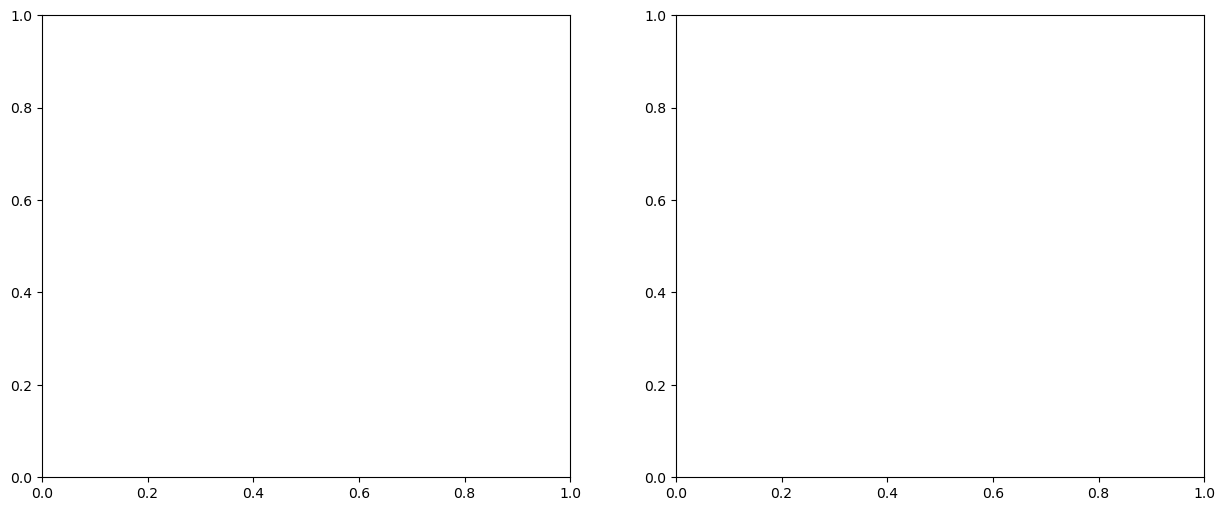

In [28]:
#Plotting
fig, axes = plt.subplots(1,2 , figsize = (15,6))

#Loss
ax = axes[0]
hist_df.plot(y = ['loss','val_loss'], ax = ax)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

#RMSE
ax1 = axes[1]
hist_df.plot(y = ['root_mean_squared_error', 'val_root_mean_squared_error'], ax = ax1)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

In [52]:
#Prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred, y_test_pred)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [53]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.422222,4.798246
48,2006-01-02,1.694444,1.490023
72,2006-01-03,2.200000,1.794739
96,2006-01-04,1.666667,1.662622
120,2006-01-05,1.805556,2.116526


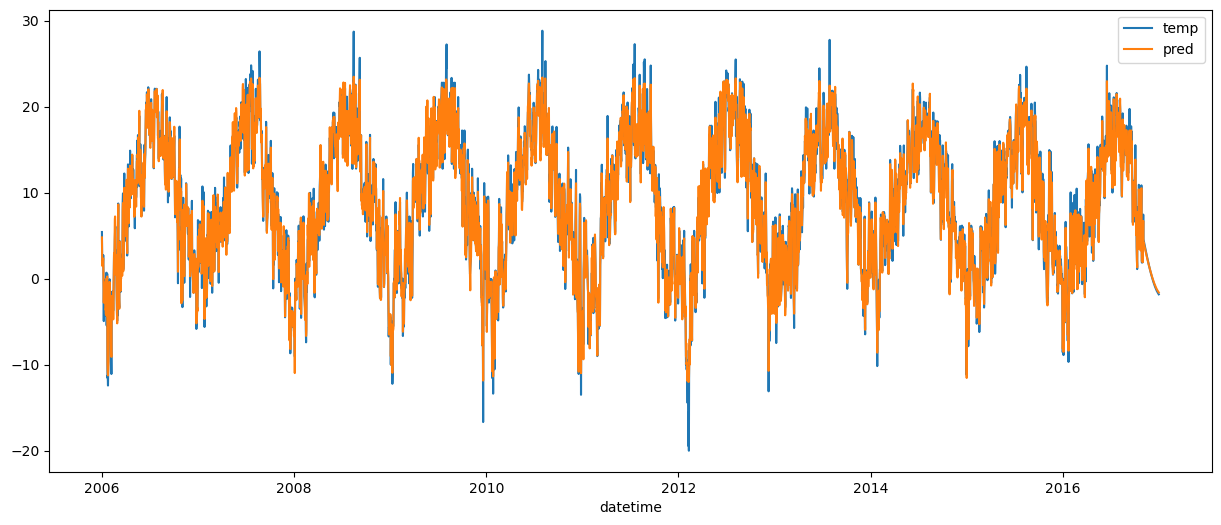

In [62]:
fig,ax=plt.subplots(figsize = (15,6))
res_df.plot(x='datetime', y=['temp','pred'],ax=ax);